# Exploratory Data Analysis

### Background
boundaries yang jelas antara buzzer dan non buzzer
kalo pake rule based mungkin bakal:

- banyak tweet dari suatu account yang pake hashtag, e.g 80% dari tweetnya pake hashtag
- banyak retweet yang mengandung hashtag atau yang bermuatan politik entah berupa text, gambar atau video
- Jika tidak menggunakan hashtag, tidak meretweet, namun sering membuat tweet yang me-mention tokoh-tokoh politik dan sangat sering e.g 70% of the tweets

In [124]:
import re
import pytz
import pickle
from datetime import datetime, timedelta, timezone
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from collections import Counter

In [2]:
tqdm.pandas()

In [3]:
def read_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [4]:
d_accounts = pd.read_csv("../data/account_labeled/project_12_labels_Thu_Oct_15_2020.csv")

In [5]:
d_199 = read_pickle("../data/supports/parsed_199.pkl")
d_6725 = read_pickle("../data/supports/parsed_7003.pkl")
d_tweets = pd.concat([d_199, d_6725], axis = 0, sort=False)
d_tweets.reset_index(drop=True, inplace=True)

In [6]:
d_tweets.drop_duplicates(subset="id_tweet", inplace=True)

In [7]:
print(f'Total tweets: {d_tweets.shape[0]:,}')

Total tweets: 1,983,967


In [8]:
d_accounts.columns = ["id", "text", "label"]

In [9]:
d_accounts.shape

(3403, 3)

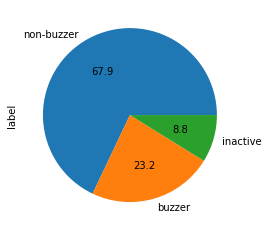

In [10]:
d_accounts.label.value_counts().plot.pie(autopct='%1.1f')
plt.savefig("../data/figures/label_percentage.png")

In [11]:
d_accounts = d_accounts[d_accounts.label != 'inactive']

In [12]:
d_accounts.shape

(3103, 3)

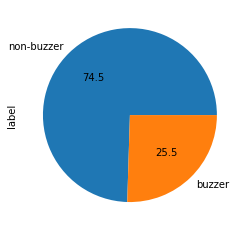

In [15]:
d_accounts.label.value_counts().plot.pie(autopct='%1.1f')

In [16]:
d_accounts['screenname'] = d_accounts.text.apply(lambda text: text.split()[0].split('/')[-1])

In [13]:
d_accounts

,id,text,label
0,2337,https://twitter.com/fahrisalam __________name:...,buzzer
1,5329,https://twitter.com/Prof_Kupie __________name:...,buzzer
2,6392,"""https://twitter.com/Syam42933824 __________na...",buzzer
3,2131,https://twitter.com/dwiawatie __________name: ...,buzzer
4,5849,https://twitter.com/saaragih __________name: L...,buzzer
5,6566,https://twitter.com/ToddJuan6 __________name: ...,buzzer
6,2969,https://twitter.com/HPtppi __________RT @Freem...,buzzer
7,4183,https://twitter.com/masarisgoplo __________nam...,buzzer
8,6198,https://twitter.com/soemartono8 __________name...,buzzer
9,5749,https://twitter.com/rodjokoyoo __________RT @J...,buzzer


In [14]:
d_tweets.head()

,screen_name,id_tweet,full_text,hashtags,user_mentions,created_at,quote_is_quote_status,quote_screen_name,quote_id_tweet,quote_full_text,quote_hashtags,quote_user_mentions,quote_created_at,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name
0,212Ujee2,1272955449160040449,#HapusRUUHIPDariMukaBumi \n#HapusRUUHIPDariMuk...,"[{'text': 'HapusRUUHIPDariMukaBumi', 'indices'...",[],Tue Jun 16 18:13:24 +0000 2020,True,Par3w4_Minang,1272901801516335112,Moncong putih ingin cuci tangan \n\nKata si Po...,[],[],Tue Jun 16 14:40:13 +0000 2020,NaN,NaN,NaN
1,212Ujee2,1272573148974571526,Sampah n benalu\nPerusak demokrasi wajib kita ...,"[{'text': 'BuzzeRpPublicEnemy', 'indices': [59...",[],Mon Jun 15 16:54:16 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,212Ujee2,1272242834725208064,Saatnya kita bersatu\nWahai umat Islam\n\n#Sto...,"[{'text': 'Stop_RUUHIP', 'indices': [39, 51]},...",[],Sun Jun 14 19:01:43 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,212Ujee2,1267860265694978049,Umat Islam\nHrs diam \nTerus sampai kapan?\nKe...,"[{'text': 'BalikinDanaHaji', 'indices': [104, ...",[],Tue Jun 02 16:46:57 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,212Ujee2,1266354000716107780,Hai Pemimpin !!!\nApakah udh ga ada lagi \nPro...,"[{'text': 'DirutBokep', 'indices': [204, 215]}...","[{'screen_name': '__p3jalan____', 'name': 'p3j...",Fri May 29 13:01:36 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
utc7 = pytz.timezone("Asia/Jakarta")

In [18]:
d_tweets["created_at_format"] = d_tweets.created_at.progress_apply(
    lambda x: datetime.strptime(x, "%a %b %d %H:%M:%S %z %Y"))

100%|█████████████████████████████████████████████████████████████████████| 1983967/1983967 [00:43<00:00, 45558.96it/s]


In [19]:
d_tweets["created_at_format"] = d_tweets.created_at_format.progress_apply(
    lambda x: x.tz_convert(utc7))

  0%|                                                                           | 1/1983967 [00:00<1:39:14, 333.17it/s]


### calculate average tweets per day given an account

In [ ]:
d_accounts.loc[:, "mean"] = d_accounts.loc[:, "screenname"].progress_apply(
    lambda screenname: d_tweets.loc[d_tweets.screen_name == screenname].groupby(
    by=d_tweets.created_at_format.dt.date)["id_tweet"].count().mean())

In [ ]:
plt.figure(figsize=(5, 8))
sns.boxplot(x = 'label', y = 'mean', data = d_accounts)

In [ ]:
plt.savefig("../data/figures/average-tweets-per-account.png")

### calculate median tweets per day given an account

In [ ]:
d_accounts.loc[:, "median"] = d_accounts.loc[:, "screenname"].progress_apply(
    lambda screenname: d_tweets.loc[d_tweets.screen_name == screenname].groupby(
    by=d_tweets.created_at_format.dt.date)["id_tweet"].count().median())

In [ ]:
plt.figure(figsize=(5, 8))
sns.boxplot(x = 'label', y = 'median', data = d_accounts)
plt.savefig("../data/figures/average-tweets-per-account.png")

### calculate average hashtags per account

In [40]:
d_accounts["average_hashtag"] = d_accounts.loc[:, "screenname"].progress_apply(
    lambda x: d_tweets.loc[d_tweets.screen_name.isin([x])].hashtags.apply(len).mean())

100%|██████████████████████████████████████████████████████████████████████████████| 3103/3103 [03:13<00:00, 16.02it/s]


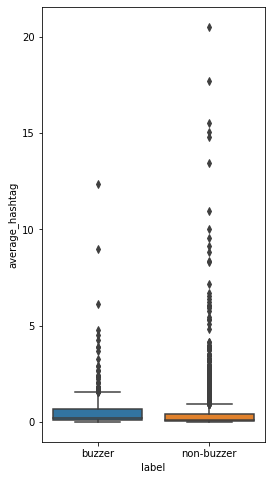

In [46]:
plt.figure(figsize=(4,8))
sns.boxplot(x = 'label', y = 'average_hashtag', data = d_accounts)
plt.savefig("../data/figures/average_hashtag_per_user.png")

### average retweet per hari

In [69]:
d_accounts["average_rt"] = d_accounts.screenname.progress_apply(lambda x:
    d_tweets[d_tweets.screen_name.isin([x])].full_text.str.contains('^RT', regex=True).mean())

100%|██████████████████████████████████████████████████████████████████████████████| 3103/3103 [03:18<00:00, 15.59it/s]


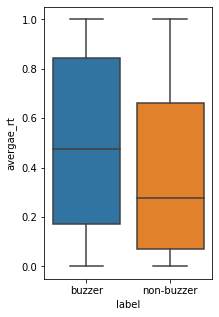

In [75]:
plt.figure(figsize=(3,5))
sns.boxplot(x = "label", y = "avergae_rt", data = d_accounts)
plt.savefig("../data/figures/average_rt_per_account.png")

### berapa banyak tweet yang pake hashtag

In [77]:
d_accounts.head()

,id,text,label,screenname,average_hashtag,avergae_rt
0,2337,https://twitter.com/fahrisalam __________name:...,buzzer,fahrisalam,0.023333,0.470000
1,5329,https://twitter.com/Prof_Kupie __________name:...,buzzer,Prof_Kupie,0.044372,0.055195
2,6392,"""https://twitter.com/Syam42933824 __________na...",buzzer,Syam42933824,0.246667,0.930000
3,2131,https://twitter.com/dwiawatie __________name: ...,buzzer,dwiawatie,0.160000,0.080000
4,5849,https://twitter.com/saaragih __________name: L...,buzzer,saaragih,0.086667,0.986667


In [106]:
d_accounts["average_tweet_contain_hashtag"] = d_accounts.screenname.progress_apply(
    lambda x: (d_tweets[d_tweets.screen_name.isin([x])].hashtags.apply(len) > 0).mean())

100%|██████████████████████████████████████████████████████████████████████████████| 3103/3103 [03:07<00:00, 16.54it/s]


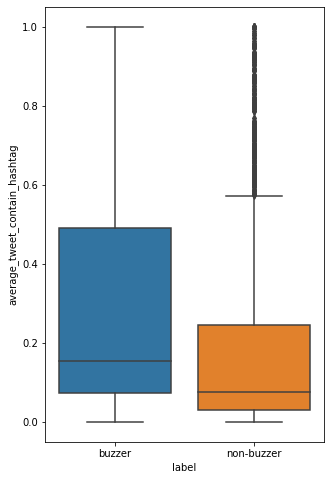

In [110]:
plt.figure(figsize=(5,8))
sns.boxplot(x = 'label', y = 'average_tweet_contain_hashtag', data = d_accounts)
plt.savefig("../data/figures/average_tweet_contain_hashtag")

In [146]:
hashtag_list = d_tweets.hashtags.apply(lambda x: [hashtag["text"] for hashtag in x]).to_list()

In [147]:
hashtag_list_flat = list(chain(*hashtag_list))

hashtag_dict = dict(Counter(hashtag_list_flat))

d_hashtag = pd.DataFrame(data={"hashtag": list(hashtag_dict.keys()), "frequency": list(hashtag_dict.values())})

In [150]:
d_hashtag.to_csv("../data/supports/hashtag.csv", index=False)

In [135]:
d_hashtag.sort_values(by="frequency", ascending=False)

,hashtag,frequency
265,programfolback,13261
3606,KawanPajak,5684
266,dirumahaja,5050
277,COVID19,4392
7282,SayNoToPDIPerjuangan,2863
7283,TurunTurunTurunJokowi,2705
194,BonekaSial,2405
7290,IndonesiaSiapPeoplePower,2397
196,TangkisKomunis,2038
1051,NewNormal,1987


In [142]:
screenname_buzzer = d_accounts.loc[d_accounts.label=="non-buzzer", "screenname"].tolist()

In [143]:
hashtag_list = d_tweets[d_tweets.screen_name.isin(screenname_buzzer)].hashtags.apply(lambda x: [hashtag["text"] for hashtag in x]).to_list()

In [144]:
hashtag_list_flat = list(chain(*hashtag_list))
hashtag_dict = dict(Counter(hashtag_list_flat))
d_hashtag = pd.DataFrame(data={"hashtag": list(hashtag_dict.keys()), "frequency": list(hashtag_dict.values())})

In [145]:
d_hashtag.sort_values(by="frequency", ascending=False)

,hashtag,frequency
2680,programfolback,3995
3830,KawanPajak,2715
294,dirumahaja,1971
46,COVID19,1587
1829,TangkisKomunis,919
27699,PajakKitaUntukKita,861
4886,togelonline,805
1826,BonekaSial,786
1827,SikatPKI,708
309,DiRumahAja,654
